# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def fmt_items(lines,max_lines=0):
    max_width=max([len(line)for line in lines])
    empty =' '*max_width
    lines = [line.ljust(max_width)for line in lines]
    lines += [empty]*(max_lines - len(lines))
    return lines
    
def pp (*list):
    lines = [ str(item).split('\n') for item in list]
    max_lines=max([len(item)for  item in lines])
    lines = [fmt_items(item,max_lines=max_lines)for item in lines]
    lines_t= np.array(lines).T
    print('\n'.join([' '.join(line) for  line in lines_t]))


In [2]:
%matplotlib nbagg

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

==GRAD_CHECK== at (0,)  num = 6.000000000039306 anal = 6.0
Gradient check passed!
==GRAD_CHECK== at (0,)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1,)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!
==GRAD_CHECK== at (0, 0)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (0, 1)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1, 0)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1, 1)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!


True

In [6]:
(array_sum(np.array([5.0, 2.0]))[0]-array_sum(np.array([1.0, 2.0]))[0])/4

1.0

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [7]:
import linear_classifer 
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
print(probs)
# assert np.isclose(probs[0], 1.0)

[2.06106005e-09 4.53978686e-05 9.99954600e-01]
[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [8]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
    
linear_classifer.cross_entropy_loss(probs, np.array(2))


IndexError: too many indices for array

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [ ]:
probs = linear_classifer.softmax(np.array([1, 0, 0]))
linear_classifer.cross_entropy_loss(probs, 0)

In [9]:
loss, grad= linear_classifer.softmax_with_cross_entropy(np.array([1., 0., 0.]), 0)
loss1, grad1= linear_classifer.softmax_with_cross_entropy(np.array([3, 0, 0]), 0)
loss2, grad2 = linear_classifer.softmax_with_cross_entropy(np.array([-1, 0, 0]), 0)
print((loss1-loss2)/4)
print('loss,grad = ',loss, grad)

enter of the function =  [1. 0. 0.] 0
soft max = [0.57611688 0.21194156 0.21194156]


AttributeError: 'int' object has no attribute 'flatten'

In [22]:
# TODO Implement combined function orsoftmax and cross entropy and produces gradient #-2.0491237621641485

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([ 1,0,0], np.float))

enter of the function =  [1. 0. 0.] 1


AttributeError: 'int' object has no attribute 'flatten'

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [9]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
pp('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
pp('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
print('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

predictions = [[ 1.  2. -1.  1.]]
targets =  [[2]]
log loss =  3.5797242232074917
log loss =  3.5797283438783922
log loss =  3.5797201026020242
==GRAD_CHECK== at (0, 0)  num = 0.20603190920009948 anal = 0.20603190919001857
log loss =  3.579735424312667
log loss =  3.5797130222008735
==GRAD_CHECK== at (0, 1)  num = 0.5600527948401712 anal = 0.5600527948339517
log loss =  3.5797047808806486
log loss =  3.5797436655451773
==GRAD_CHECK== at (0, 2)  num = -0.9721166132181657 anal = -0.9721166132139888
log loss =  3.5797283438783922
log loss =  3.5797201026020242
==GRAD_CHECK== at (0, 3)  num = 0.20603190920009948 anal = 0.20603190919001857
Gradient check passed!
predictions = [[ 2. -1. -1.  1.]
 [ 0.  1.  1.  1.]
 [ 1.  2. -1.  2.]]
targets =  [[3]
 [3]
 [2]]
log loss =  9.901861007689417
log loss =  9.901872717171424
log loss =  9.901849298395895
==GRAD_CHECK== at (0, 0)  num = 0.19515646273449147 anal = 0.19515646271894127
log loss =  9.901861590671281
log loss =  9.901860424719102
==GRAD

True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [10]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)


loss, dW = linear_classifer.linear_softmax(X, W, target_index)
pp(dW)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

log loss =  4.370364905207625
[[-0.11245721  0.48478057] 
 [-0.07108652  0.81573323] 
 [ 0.15382791 -0.15382791]]
log loss =  4.370364905207625
log loss =  4.370360406959003
log loss =  4.370369403536097
==GRAD_CHECK== at (0, 0)  num = -0.11245721367458826 anal = -0.11245721367093255
log loss =  4.370384296436465
log loss =  4.370345513990775
==GRAD_CHECK== at (0, 1)  num = 0.4847805711305497 anal = 0.48478057113584405
log loss =  4.370362061806466
log loss =  4.370367748727805
==GRAD_CHECK== at (1, 0)  num = -0.07108651673970456 anal = -0.0710865167499724
log loss =  4.370397534609193
log loss =  4.370332275950659
==GRAD_CHECK== at (1, 1)  num = 0.8157332316738318 anal = 0.8157332316797954
log loss =  4.370371058376115
log loss =  4.370358752143268
==GRAD_CHECK== at (2, 0)  num = 0.15382791058726752 anal = 0.15382791059189269
log loss =  4.370358752143268
log loss =  4.370371058376115
==GRAD_CHECK== at (2, 1)  num = -0.15382791058726752 anal = -0.1538279105918927
Gradient check passed

True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [11]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

==GRAD_CHECK== at (0, 0)  num = 0.009999999999940612 anal = 0.01
==GRAD_CHECK== at (0, 1)  num = 0.02000000000022817 anal = 0.02
==GRAD_CHECK== at (1, 0)  num = -0.009999999999940612 anal = -0.01
==GRAD_CHECK== at (1, 1)  num = 0.009999999999940612 anal = 0.01
==GRAD_CHECK== at (2, 0)  num = 0.009999999999940612 anal = 0.01
==GRAD_CHECK== at (2, 1)  num = 0.02000000000022817 anal = 0.02
Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [12]:
# TODO: Implement LinearSoftmaxClassifier.fit function 
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)
'''THERE WERE 10 EPOCHS   !!!!!
'''

log loss =  102671.3413754061
Epoch 0, loss: 11.438614
== W == 0.015367261325207056
log loss =  102670.96466120379
Epoch 1, loss: 11.437961
== W == 0.015085558438602847
log loss =  102670.5928852757
Epoch 2, loss: 11.437320
== W == 0.014808943099298658
log loss =  102670.2259652477
Epoch 3, loss: 11.436692
== W == 0.014537309014583003
log loss =  102669.86382058142
Epoch 4, loss: 11.436077
== W == 0.014270552564537253
log loss =  102669.50637252312
Epoch 5, loss: 11.435473
== W == 0.014008572722868672
log loss =  102669.15354405412
Epoch 6, loss: 11.434881
== W == 0.01375127098036174
log loss =  102668.80525984285
Epoch 7, loss: 11.434301
== W == 0.013498551270855093
log loss =  102668.46144619831
Epoch 8, loss: 11.433732
== W == 0.013250319899654427
log loss =  102668.12203102512
Epoch 9, loss: 11.433174
== W == 0.01300648547429593


'THERE WERE 10 EPOCHS   !!!!!\n'

[11.438613883758585, 11.43796059130765, 11.437320100386984, 11.436692156753265, 11.436076511269762, 11.435472919802418, 11.434881143118098, 11.434300946784926, 11.433732101074703, 11.433174380867348]


<IPython.core.display.Javascript object>


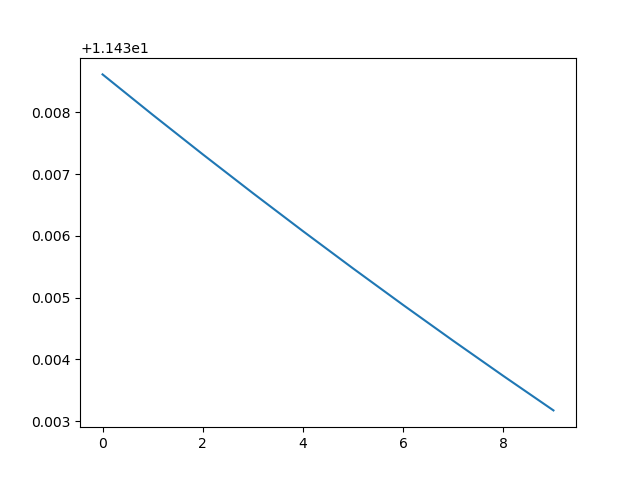

In [13]:
# let's look at the loss history!
print(loss_history)
plt.plot(loss_history)

In [7]:
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=300, learning_rate=1e-1, batch_size=300, reg=1e-1)

log loss =  102665.25674170148
Epoch 0, loss: 11.407554
== W == -0.006462966065634238
log loss =  102634.65663520005
Epoch 1, loss: 11.404153
== W == -0.01635493060551719
log loss =  102608.19571478163
Epoch 2, loss: 11.401216
== W == -0.02370572515356686
log loss =  102583.00957646607
Epoch 3, loss: 11.398427
== W == -0.028298149167244546
log loss =  102558.79776040118
Epoch 4, loss: 11.395750
== W == -0.03149263047428386
log loss =  102535.47957350557
Epoch 5, loss: 11.393178
== W == -0.03421848783494706
log loss =  102512.99921605366
Epoch 6, loss: 11.390703
== W == -0.03689785762256774
log loss =  102491.30789095745
Epoch 7, loss: 11.388320
== W == -0.039684284850195525
log loss =  102470.36146608801
Epoch 8, loss: 11.386023
== W == -0.042618291933861366
log loss =  102450.119739669
Epoch 9, loss: 11.383809
== W == -0.045698704035425086
log loss =  102430.545962054
Epoch 10, loss: 11.381671
== W == -0.048910964555609095
log loss =  102411.60644523769
Epoch 11, loss: 11.379607
== W 

log loss =  101787.02145381391
Epoch 96, loss: 11.314968
== W == -0.2707702377156455
log loss =  101784.63604886609
Epoch 97, loss: 11.314740
== W == -0.27196110869000845
log loss =  101782.2968543188
Epoch 98, loss: 11.314517
== W == -0.27312998781517905
log loss =  101780.0028190295
Epoch 99, loss: 11.314298
== W == -0.27427726265262387
log loss =  101777.75292011385
Epoch 100, loss: 11.314083
== W == -0.27540331550781993
log loss =  101775.5461620605
Epoch 101, loss: 11.313873
== W == -0.27650852342186044
log loss =  101773.38157587736
Epoch 102, loss: 11.313667
== W == -0.2775932581676691
log loss =  101771.25821826738
Epoch 103, loss: 11.313465
== W == -0.2786578862505482
log loss =  101769.17517083381
Epoch 104, loss: 11.313267
== W == -0.279702768912816
log loss =  101767.13153931292
Epoch 105, loss: 11.313073
== W == -0.28072826214229196
log loss =  101765.12645283341
Epoch 106, loss: 11.312883
== W == -0.2817347166844122
log loss =  101763.15906320186
Epoch 107, loss: 11.31269

Epoch 191, loss: 11.304774
== W == -0.32430074617904037
log loss =  101677.5390644134
Epoch 192, loss: 11.304732
== W == -0.3245089609395258
log loss =  101677.08306029093
Epoch 193, loss: 11.304690
== W == -0.32471357388212996
log loss =  101676.63407670273
Epoch 194, loss: 11.304649
== W == -0.32491465218386834
log loss =  101676.1919940355
Epoch 195, loss: 11.304609
== W == -0.3251122616910369
log loss =  101675.75669495678
Epoch 196, loss: 11.304569
== W == -0.3253064669461702
log loss =  101675.32806436603
Epoch 197, loss: 11.304530
== W == -0.325497331214479
log loss =  101674.90598934656
Epoch 198, loss: 11.304492
== W == -0.32568491650978293
log loss =  101674.49035911914
Epoch 199, loss: 11.304454
== W == -0.3258692836199375
log loss =  101674.08106499615
Epoch 200, loss: 11.304417
== W == -0.3260504921317679
log loss =  101673.67800033736
Epoch 201, loss: 11.304380
== W == -0.32622860045551816
log loss =  101673.28106050642
Epoch 202, loss: 11.304344
== W == -0.32640366584881

Epoch 286, loss: 11.302630
== W == -0.3342532067523769
log loss =  101654.19603488198
Epoch 287, loss: 11.302619
== W == -0.33429704364426116
log loss =  101654.08123122729
Epoch 288, loss: 11.302609
== W == -0.33434020738926407
log loss =  101653.96798900777
Epoch 289, loss: 11.302599
== W == -0.33438270899223294
log loss =  101653.85628544484
Epoch 290, loss: 11.302589
== W == -0.3344245592638628
log loss =  101653.74609812108
Epoch 291, loss: 11.302579
== W == -0.3344657688244047
log loss =  101653.63740497401
Epoch 292, loss: 11.302569
== W == -0.33450634810730384
log loss =  101653.5301842898
Epoch 293, loss: 11.302560
== W == -0.33454630736275803
log loss =  101653.42441469741
Epoch 294, loss: 11.302550
== W == -0.3345856566612075
log loss =  101653.32007516251
Epoch 295, loss: 11.302541
== W == -0.33462440589674947
log loss =  101653.21714498173
Epoch 296, loss: 11.302531
== W == -0.334662564790486
log loss =  101653.11560377697
Epoch 297, loss: 11.302522
== W == -0.334700142893

[11.407554432210441, 11.404152525156267, 11.401216187166025, 11.398426696909004, 11.395750438699375, 11.393178139055307, 11.390703274316005, 11.388320110249639, 11.386023449627787, 11.383808551397292, 11.381671076535616, 11.379607043261316, 11.377612788236426, 11.375684932543338, 11.373820351727199, 11.372016149375447, 11.370269633798102, 11.368578297434173, 11.366939798657555, 11.365351945695833, 11.363812682409861, 11.36232007571192, 11.360872304426405, 11.359467649420022, 11.35810448484891, 11.356781270387868, 11.355496544322945, 11.354248917402696, 11.353037067355794, 11.35185973399394, 11.350715714828686, 11.349603861139517, 11.348523074438292, 11.347472303281803, 11.346450540390373, 11.34545682003555, 11.344490215664695, 11.343549837734368, 11.342634831727889, 11.341744376335733, 11.3408776817801, 11.34003398826738, 11.339212564554382, 11.338412706615983, 11.337633736403488, 11.3368750006843, 11.336135869954754, 11.335415737418998, 11.334714018027688, 11.334030147571045, 11.33336

<IPython.core.display.Javascript object>


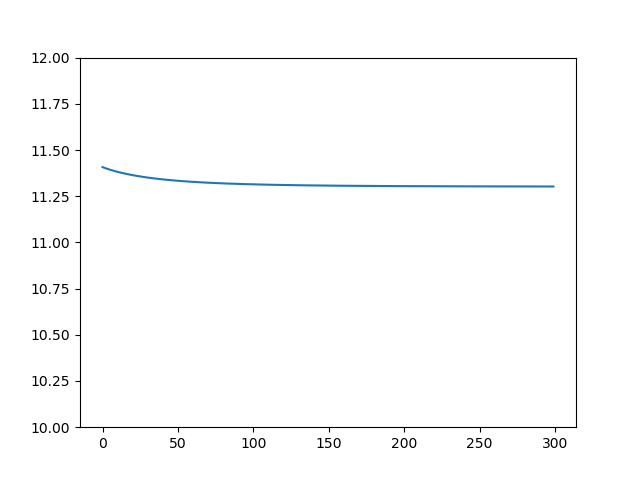

(10, 12)

In [8]:
print(loss_history)
plt.plot(loss_history)
plt.gca().set_ylim(10,12)

log loss =  102664.42468084252
Epoch 0, loss: 11.438023
== W == -6.036378324860552
log loss =  136800.60254381853
Epoch 1, loss: 320.642178
== W == 1415.6879791892497


D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:38: RuntimeWarning: divide by zero encountered in log
  log =   np.sum(- np.log(probs[np.arange(probs.shape[0]),target_index.flatten()]))


log loss =  inf
Epoch 2, loss: inf
== W == -155492.7233192813
log loss =  inf
Epoch 3, loss: inf
== W == 15404846.74032562
log loss =  inf
Epoch 4, loss: inf
== W == -1525095166.9056184
log loss =  inf
Epoch 5, loss: inf
== W == 150984432590.78793
log loss =  inf
Epoch 6, loss: inf
== W == -14947458841827.623
log loss =  inf
Epoch 7, loss: inf
== W == 1479798425352002.0
log loss =  inf
Epoch 8, loss: inf
== W == -1.4650004410986355e+17
log loss =  inf
Epoch 9, loss: inf
== W == 1.450350436687649e+19
log loss =  inf
Epoch 0, loss: inf
== W == -1.4358469323207722e+21
log loss =  inf
Epoch 1, loss: inf
== W == 1.421488462997565e+23
log loss =  inf
Epoch 2, loss: inf
== W == -1.407273578367589e+25
log loss =  inf
Epoch 3, loss: inf
== W == 1.3932008425839132e+27
log loss =  inf
Epoch 4, loss: inf
== W == -1.3792688341580739e+29
log loss =  inf
Epoch 5, loss: inf
== W == 1.3654761458164933e+31
log loss =  inf
Epoch 6, loss: inf
== W == -1.3518213843583285e+33
log loss =  inf
Epoch 7, loss: 

c:\users\сергей\.virtualenvs\layman-s-deep-learning--lrbitjvr\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:98: RuntimeWarning: overflow encountered in square
  loss = reg_strength * np.sum(W**2)


Epoch 8, loss: inf
== W == -7.249388545869601e+156
log loss =  inf
Epoch 9, loss: inf
== W == 7.176894660410911e+158
log loss =  inf
Epoch 0, loss: inf
== W == -7.1051257138068e+160
log loss =  inf
Epoch 1, loss: inf
== W == 7.034074456668732e+162
log loss =  inf
Epoch 2, loss: inf
== W == -6.963733712102046e+164
log loss =  inf
Epoch 3, loss: inf
== W == 6.894096374981025e+166
log loss =  inf
Epoch 4, loss: inf
== W == -6.825155411231221e+168
log loss =  inf
Epoch 5, loss: inf
== W == 6.756903857118903e+170
log loss =  inf
Epoch 6, loss: inf
== W == -6.689334818547713e+172
log loss =  inf
Epoch 7, loss: inf
== W == 6.622441470362236e+174
log loss =  inf
Epoch 8, loss: inf
== W == -6.556217055658617e+176
log loss =  inf
Epoch 9, loss: inf
== W == 6.490654885102029e+178
log loss =  inf
Epoch 0, loss: inf
== W == -6.4257483362510075e+180
log loss =  inf
Epoch 1, loss: inf
== W == 6.361490852888499e+182
log loss =  inf
Epoch 2, loss: inf
== W == -6.297875944359614e+184
log loss =  inf
Epo

c:\users\сергей\.virtualenvs\layman-s-deep-learning--lrbitjvr\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:15: RuntimeWarning: invalid value encountered in subtract
  s_pred =predictions-np.max(predictions)



== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan


log loss =  inf
Epoch 2, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 3, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 4, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 5, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 6, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 7, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 8, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 9, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 0, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 1, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 2, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 3, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 4, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 5, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 6, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 7, loss: inf
== W == -15348.907498910678


log loss =  inf
Epoch 3, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 4, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 5, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 6, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 7, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 8, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 9, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 0, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 1, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 2, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 3, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 4, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 5, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 6, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 7, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 8, loss: inf
== W == 11067.131716775602


log loss =  inf
Epoch 5, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 6, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 7, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 8, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 9, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 0, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 1, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 2, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 3, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 4, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 5, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 6, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 7, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 8, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 9, loss: inf
== W == -15348.907498910678
log loss =  102671.21560466467
Epoch 0, loss: 11.407943
== W =

log loss =  inf
Epoch 7, loss: inf
== W == -8103.34208634845
log loss =  inf
Epoch 8, loss: inf
== W == 3032.9473684737595
log loss =  inf
Epoch 9, loss: inf
== W == -12609.936633140367
log loss =  inf
Epoch 0, loss: inf
== W == -281.8112530507304
log loss =  2486822.4777789842
Epoch 1, loss: 295.533674
== W == -6142.581364500962
log loss =  inf
Epoch 2, loss: inf
== W == 5538.808488724734
log loss =  inf
Epoch 3, loss: inf
== W == -10354.685741411357
log loss =  inf
Epoch 4, loss: inf
== W == 1747.9145495053785
log loss =  inf
Epoch 5, loss: inf
== W == -9856.530543805937
log loss =  inf
Epoch 6, loss: inf
== W == 2196.2542273502554
log loss =  inf
Epoch 7, loss: inf
== W == -10973.690459001327
log loss =  inf
Epoch 8, loss: inf
== W == 1190.8103036744042
log loss =  inf
Epoch 9, loss: inf
== W == -4271.266618034726
log loss =  inf
Epoch 0, loss: inf
== W == 4421.1878389758385
log loss =  inf
Epoch 1, loss: inf
== W == -11369.838443832421
log loss =  inf
Epoch 2, loss: inf
== W == 834

log loss =  inf
Epoch 9, loss: inf
== W == 1072.9273273725605
log loss =  inf
Epoch 0, loss: inf
== W == -12036.934947652102
log loss =  inf
Epoch 1, loss: inf
== W == 233.89026388870684
log loss =  inf
Epoch 2, loss: inf
== W == -9275.768489127255
log loss =  inf
Epoch 3, loss: inf
== W == 2718.94007656107
log loss =  inf
Epoch 4, loss: inf
== W == -12901.861430005712
log loss =  inf
Epoch 5, loss: inf
== W == -544.5435702295426
log loss =  inf
Epoch 6, loss: inf
== W == -9039.898672261777
log loss =  inf
Epoch 7, loss: inf
== W == 2190.046441151764
log loss =  inf
Epoch 8, loss: inf
== W == -12136.219803437172
log loss =  inf
Epoch 9, loss: inf
== W == 144.5338936821443
log loss =  inf
Epoch 0, loss: inf
== W == -12676.8662102819
log loss =  inf
Epoch 1, loss: inf
== W == -342.0478724781118
log loss =  2513862.4122534525
Epoch 2, loss: 297.962293
== W == -11302.548258328181
log loss =  inf
Epoch 3, loss: inf
== W == 894.8382842802364
log loss =  inf
Epoch 4, loss: inf
== W == -6107.2

log loss =  102638.38315492631
Epoch 8, loss: 11.404585
== W == -0.0014925859343312628
log loss =  102638.38315492235
Epoch 9, loss: 11.404585
== W == -0.001492586495418558
log loss =  102638.38315492516
Epoch 0, loss: 11.404585
== W == -0.001492586093357714
log loss =  102638.38315492317
Epoch 1, loss: 11.404585
== W == -0.001492586381421586
log loss =  102638.3831549246
Epoch 2, loss: 11.404585
== W == -0.0014925861750623376
log loss =  102638.38315492359
Epoch 3, loss: 11.404585
== W == -0.0014925863228708609
log loss =  102638.38315492429
Epoch 4, loss: 11.404585
== W == -0.0014925862170143344
log loss =  102638.3831549238
Epoch 5, loss: 11.404585
== W == -0.0014925862928163326
log loss =  102638.38315492414
Epoch 6, loss: 11.404585
== W == -0.0014925862385424763
log loss =  102638.38315492388
Epoch 7, loss: 11.404585
== W == -0.001492586277397701
log loss =  102638.38315492407
Epoch 8, loss: 11.404585
== W == -0.0014925862495839943
log loss =  102638.38315492393
Epoch 9, loss: 11.

Epoch 4, loss: 11.404585
== W == -0.001492586261187165
log loss =  102638.383154924
Epoch 5, loss: 11.404585
== W == -0.001492586261187192
log loss =  102638.383154924
Epoch 6, loss: 11.404585
== W == -0.0014925862611872092
log loss =  102638.383154924
Epoch 7, loss: 11.404585
== W == -0.0014925862611871684
log loss =  102638.383154924
Epoch 8, loss: 11.404585
== W == -0.0014925862611871877
log loss =  102638.383154924
Epoch 9, loss: 11.404585
== W == -0.0014925862611872066
log loss =  102638.383154924
Epoch 0, loss: 11.404585
== W == -0.0014925862611871652
log loss =  102638.38315492398
Epoch 1, loss: 11.404585
== W == -0.001492586261187223
log loss =  102638.38315492398
Epoch 2, loss: 11.404585
== W == -0.0014925862611872094
log loss =  102638.383154924
Epoch 3, loss: 11.404585
== W == -0.001492586261187191
log loss =  102638.383154924
Epoch 4, loss: 11.404585
== W == -0.0014925862611872038
log loss =  102638.383154924
Epoch 5, loss: 11.404585
== W == -0.001492586261187179
log loss =

log loss =  102638.383154924
Epoch 1, loss: 11.404585
== W == -0.0014925862611871897
log loss =  102638.383154924
Epoch 2, loss: 11.404585
== W == -0.0014925862611871853
log loss =  102638.383154924
Epoch 3, loss: 11.404585
== W == -0.0014925862611871797
log loss =  102638.383154924
Epoch 4, loss: 11.404585
== W == -0.0014925862611871873
log loss =  102638.383154924
Epoch 5, loss: 11.404585
== W == -0.001492586261187181
log loss =  102638.383154924
Epoch 6, loss: 11.404585
== W == -0.0014925862611871663
log loss =  102638.38315492398
Epoch 7, loss: 11.404585
== W == -0.0014925862611871923
log loss =  102638.38315492398
Epoch 8, loss: 11.404585
== W == -0.001492586261187208
log loss =  102638.383154924
Epoch 9, loss: 11.404585
== W == -0.001492586261187149
log loss =  102638.383154924
Epoch 0, loss: 11.404585
== W == -0.0014925862611872493
log loss =  102638.383154924
Epoch 1, loss: 11.404585
== W == -0.0014925862611871925
log loss =  102638.38315492398
Epoch 2, loss: 11.404585
== W == 

Epoch 7, loss: 11.335537
== W == -0.17000362544509612
log loss =  101988.00115525241
Epoch 8, loss: 11.334832
== W == -0.17294469962155332
log loss =  101981.23721856758
Epoch 9, loss: 11.334145
== W == -0.17583870732693876
log loss =  101974.63390183655
Epoch 0, loss: 11.333476
== W == -0.17868601856899405
log loss =  101968.18662002396
Epoch 1, loss: 11.332823
== W == -0.18148703247362843
log loss =  101961.89094168265
Epoch 2, loss: 11.332187
== W == -0.18424217380288269
log loss =  101955.74258296278
Epoch 3, loss: 11.331566
== W == -0.18695188979691385
log loss =  101949.73740191796
Epoch 4, loss: 11.330961
== W == -0.18961664731153166
log loss =  101943.87139308584
Epoch 5, loss: 11.330371
== W == -0.19223693022523805
log loss =  101938.14068232343
Epoch 6, loss: 11.329795
== W == -0.19481323709191495
log loss =  101932.54152187922
Epoch 7, loss: 11.329234
== W == -0.1973460790173042
log loss =  101927.07028568673
Epoch 8, loss: 11.328686
== W == -0.19983597773925096
log loss =  

log loss =  101709.92872244111
Epoch 5, loss: 11.307708
== W == -0.30783662668170986
log loss =  101708.9480716625
Epoch 6, loss: 11.307617
== W == -0.30833099930905156
log loss =  101707.9839750592
Epoch 7, loss: 11.307528
== W == -0.3088164033278461
log loss =  101707.03611609341
Epoch 8, loss: 11.307441
== W == -0.30929301076221305
log loss =  101706.10418517629
Epoch 9, loss: 11.307354
== W == -0.309760990322152
log loss =  101705.18787949115
Epoch 0, loss: 11.307270
== W == -0.31022050746066787
log loss =  101704.28690282222
Epoch 1, loss: 11.307186
== W == -0.3106717244303426
log loss =  101703.40096538815
Epoch 2, loss: 11.307105
== W == -0.3111148003393326
log loss =  101702.52978368053
Epoch 3, loss: 11.307024
== W == -0.31154989120677723
log loss =  101701.67308030702
Epoch 4, loss: 11.306945
== W == -0.3119771500176015
log loss =  101700.83058383901
Epoch 5, loss: 11.306867
== W == -0.31239672677670205
log loss =  101700.0020286638
Epoch 6, loss: 11.306791
== W == -0.3128087

log loss =  101661.2521100487
Epoch 3, loss: 11.303254
== W == -0.3310547344789042
log loss =  101661.03869135548
Epoch 4, loss: 11.303235
== W == -0.3311466967757947
log loss =  101660.8283237622
Epoch 5, loss: 11.303216
== W == -0.33123720049029937
log loss =  101660.6209598549
Epoch 6, loss: 11.303198
== W == -0.33132627065314035
log loss =  101660.41655303027
Epoch 7, loss: 11.303179
== W == -0.3314139318281072
log loss =  101660.21505748015
Epoch 8, loss: 11.303161
== W == -0.33150020812143244
log loss =  101660.01642817666
Epoch 9, loss: 11.303143
== W == -0.33158512319096495
log loss =  101659.8206208574
Epoch 0, loss: 11.303125
== W == -0.3316687002551567
log loss =  101659.62759201111
Epoch 1, loss: 11.303108
== W == -0.33175096210185306
log loss =  101659.43729886349
Epoch 2, loss: 11.303091
== W == -0.331831931096903
log loss =  101659.24969936353
Epoch 3, loss: 11.303074
== W == -0.33191162919258743
log loss =  101659.0647521698
Epoch 4, loss: 11.303057
== W == -0.331990077

Epoch 0, loss: 11.329510
== W == -0.1896282132864779
log loss =  101951.6188411984
Epoch 1, loss: 11.328296
== W == -0.19488665749813622
log loss =  101940.79430153499
Epoch 2, loss: 11.327105
== W == -0.20012504477828202
log loss =  101930.17277909287
Epoch 3, loss: 11.325937
== W == -0.20534247151884924
log loss =  101919.74960242545
Epoch 4, loss: 11.324791
== W == -0.21053810641243997
log loss =  101909.5202180266
Epoch 5, loss: 11.323667
== W == -0.21571118484622592
log loss =  101899.4801856789
Epoch 6, loss: 11.322563
== W == -0.22086100376173384
log loss =  101889.62517424105
Epoch 7, loss: 11.321481
== W == -0.22598691694174017
log loss =  101879.95095781777
Epoch 8, loss: 11.320418
== W == -0.2310883306893013
log loss =  101870.45341226198
Epoch 9, loss: 11.319375
== W == -0.236164699867219
log loss =  101861.12851196586
Epoch 0, loss: 11.318351
== W == -0.24121552426909088
log loss =  101851.97232690247
Epoch 1, loss: 11.317347
== W == -0.2462403452955727
log loss =  101842.

log loss =  101420.90209715575
Epoch 8, loss: 11.270525
== W == -0.57737990495856
log loss =  101418.21304332322
Epoch 9, loss: 11.270237
== W == -0.5801307004137559
log loss =  101415.55044951355
Epoch 0, loss: 11.269953
== W == -0.5828633147093378
log loss =  101412.91386479065
Epoch 1, loss: 11.269671
== W == -0.5855779455153081
log loss =  101410.30284831898
Epoch 2, loss: 11.269391
== W == -0.5882747888192732
log loss =  101407.71696910699
Epoch 3, loss: 11.269115
== W == -0.5909540388898842
log loss =  101405.15580575737
Epoch 4, loss: 11.268841
== W == -0.5936158882432131
log loss =  101402.618946224
Epoch 5, loss: 11.268570
== W == -0.5962605276119598
log loss =  101400.10598757524
Epoch 6, loss: 11.268302
== W == -0.5988881459173798
log loss =  101397.61653576359
Epoch 7, loss: 11.268036
== W == -0.6014989302438425
log loss =  101395.15020540144
Epoch 8, loss: 11.267773
== W == -0.604093065815908
log loss =  101392.7066195427
Epoch 9, loss: 11.267512
== W == -0.606670735977829

Epoch 6, loss: 11.251238
== W == -0.7839778280422338
log loss =  101237.57086927356
Epoch 7, loss: 11.251102
== W == -0.7856131792248938
log loss =  101236.27104765883
Epoch 8, loss: 11.250965
== W == -0.7872416094027361
log loss =  101234.97842200666
Epoch 9, loss: 11.250830
== W == -0.7888631709512326
log loss =  101233.69292174182
Epoch 0, loss: 11.250696
== W == -0.7904779155078907
log loss =  101232.41447732547
Epoch 1, loss: 11.250562
== W == -0.7920858939846908
log loss =  101231.14302023535
Epoch 2, loss: 11.250429
== W == -0.7936871565803422
log loss =  101229.87848294625
Epoch 3, loss: 11.250296
== W == -0.7952817527923475
log loss =  101228.620798911
Epoch 4, loss: 11.250165
== W == -0.7968697314288989
log loss =  101227.36990254167
Epoch 5, loss: 11.250034
== W == -0.7984511406205774
log loss =  101226.12572919163
Epoch 6, loss: 11.249904
== W == -0.8000260278318911
log loss =  101224.8882151375
Epoch 7, loss: 11.249775
== W == -0.8015944398726201
log loss =  101223.6572975

Epoch 3, loss: 11.404686
== W == -0.00130177006202777
log loss =  102639.1071119999
Epoch 4, loss: 11.404673
== W == -0.0013301881158911558
log loss =  102639.03334708161
Epoch 5, loss: 11.404662
== W == -0.001354174776740277
log loss =  102638.96712302844
Epoch 6, loss: 11.404652
== W == -0.0013744403593826668
log loss =  102638.90766479052
Epoch 7, loss: 11.404644
== W == -0.0013915795992887824
log loss =  102638.85427768521
Epoch 8, loss: 11.404637
== W == -0.001406090602419379
log loss =  102638.8063389415
Epoch 9, loss: 11.404631
== W == -0.0014183906765011687
log loss =  102638.76329015537
Epoch 0, loss: 11.404625
== W == -0.0014288295581103257
log loss =  102638.72463055435
Epoch 1, loss: 11.404620
== W == -0.0014377004648845186
log loss =  102638.68991098106
Epoch 2, loss: 11.404616
== W == -0.0014452493312623466
log loss =  102638.65872851666
Epoch 3, loss: 11.404613
== W == -0.001451682526982647
log loss =  102638.63072167424
Epoch 4, loss: 11.404610
== W == -0.00145717330820

Epoch 8, loss: 11.404585
== W == -0.0014925817299064846
log loss =  102638.38318309555
Epoch 9, loss: 11.404585
== W == -0.0014925821642416777
log loss =  102638.38318024477
Epoch 0, loss: 11.404585
== W == -0.0014925825571389802
log loss =  102638.38317768252
Epoch 1, loss: 11.404585
== W == -0.0014925829125316003
log loss =  102638.38317537961
Epoch 2, loss: 11.404585
== W == -0.0014925832339814332
log loss =  102638.38317330976
Epoch 3, loss: 11.404585
== W == -0.0014925835247139034
log loss =  102638.38317144939
Epoch 4, loss: 11.404585
== W == -0.001492583787649623
log loss =  102638.38316977731
Epoch 5, loss: 11.404585
== W == -0.001492584025432997
log loss =  102638.38316827445
Epoch 6, loss: 11.404585
== W == -0.0014925842404582366
log loss =  102638.38316692365
Epoch 7, loss: 11.404585
== W == -0.0014925844348928625
log loss =  102638.38316570957
Epoch 8, loss: 11.404585
== W == -0.001492584610699071
log loss =  102638.38316461834
Epoch 9, loss: 11.404585
== W == -0.0014925847

log loss =  102638.38315492525
Epoch 3, loss: 11.404585
== W == -0.0014925862609206923
log loss =  102638.38315492512
Epoch 4, loss: 11.404585
== W == -0.0014925862609469634
log loss =  102638.383154925
Epoch 5, loss: 11.404585
== W == -0.001492586260970645
log loss =  102638.3831549249
Epoch 6, loss: 11.404585
== W == -0.0014925862609920055
log loss =  102638.38315492481
Epoch 7, loss: 11.404585
== W == -0.0014925862610112562
log loss =  102638.38315492473
Epoch 8, loss: 11.404585
== W == -0.001492586261028611
log loss =  102638.38315492467
Epoch 9, loss: 11.404585
== W == -0.0014925862610442506
log loss =  102638.3831549246
Epoch 0, loss: 11.404585
== W == -0.0014925862610583483
log loss =  102638.38315492454
Epoch 1, loss: 11.404585
== W == -0.0014925862610710623
log loss =  102638.3831549245
Epoch 2, loss: 11.404585
== W == -0.0014925862610825273
log loss =  102638.38315492442
Epoch 3, loss: 11.404585
== W == -0.001492586261092858
log loss =  102638.38315492438
Epoch 4, loss: 11.40

log loss =  102613.42804843874
Epoch 9, loss: 11.401797
== W == 0.08465047486670237
log loss =  102610.82976082027
Epoch 0, loss: 11.401509
== W == 0.0775646245439559
log loss =  102608.24672346866
Epoch 1, loss: 11.401222
== W == 0.07094431221322861
log loss =  102605.67815835762
Epoch 2, loss: 11.400937
== W == 0.06475726099448617
log loss =  102603.12338542365
Epoch 3, loss: 11.400654
== W == 0.05897349923602956
log loss =  102600.58180918671
Epoch 4, loss: 11.400373
== W == 0.053565184954569946
log loss =  102598.05290721837
Epoch 5, loss: 11.400093
== W == 0.048506445129786836
log loss =  102595.53622020019
Epoch 6, loss: 11.399814
== W == 0.04377322841048315
log loss =  102593.03134335199
Epoch 7, loss: 11.399536
== W == 0.039343169950760926
log loss =  102590.53791904023
Epoch 8, loss: 11.399260
== W == 0.03519546723574889
log loss =  102588.05563040289
Epoch 9, loss: 11.398985
== W == 0.031310765880070805
log loss =  102585.58419585016
Epoch 0, loss: 11.398712
== W == 0.0276710

log loss =  102403.59629442128
Epoch 6, loss: 11.378735
== W == -0.045297220472541436
log loss =  102401.77550921013
Epoch 7, loss: 11.378537
== W == -0.0456603729403673
log loss =  102399.96051488596
Epoch 8, loss: 11.378340
== W == -0.04602379420546901
log loss =  102398.15128388912
Epoch 9, loss: 11.378143
== W == -0.04638750560291221
log loss =  102396.34778887482
Epoch 0, loss: 11.377947
== W == -0.04675152617235012
log loss =  102394.55000271046
Epoch 1, loss: 11.377752
== W == -0.04711587282242969
log loss =  102392.75789847365
Epoch 2, loss: 11.377557
== W == -0.047480560484044344
log loss =  102390.97144944963
Epoch 3, loss: 11.377363
== W == -0.047845602253184405
log loss =  102389.19062912911
Epoch 4, loss: 11.377170
== W == -0.04821100952408064
log loss =  102387.41541120606
Epoch 5, loss: 11.376977
== W == -0.04857679211329441
log loss =  102385.64576957542
Epoch 6, loss: 11.376785
== W == -0.04894295837536052
log loss =  102383.88167833097
Epoch 7, loss: 11.376593
== W ==

log loss =  102250.4962650689
Epoch 3, loss: 11.362233
== W == -0.08188477536027122
log loss =  102249.13396060665
Epoch 4, loss: 11.362088
== W == -0.0822676238933052
log loss =  102247.77550821274
Epoch 5, loss: 11.361943
== W == -0.08265038784674981
log loss =  102246.42089348468
Epoch 6, loss: 11.361798
== W == -0.08303306231991493
log loss =  102245.07010210097
Epoch 7, loss: 11.361654
== W == -0.08341564246697217
log loss =  102243.72311982031
Epoch 8, loss: 11.361511
== W == -0.08379812349649625
log loss =  102242.37993248101
Epoch 9, loss: 11.361367
== W == -0.0841805006709993
log loss =  102241.04052600019
Epoch 0, loss: 11.361225
== W == -0.08456276930646389
log loss =  102239.70488637305
Epoch 1, loss: 11.361082
== W == -0.08494492477186998
log loss =  102238.37299967234
Epoch 2, loss: 11.360940
== W == -0.08532696248872244
log loss =  102237.0448520475
Epoch 3, loss: 11.360799
== W == -0.08570887793057388
log loss =  102235.72042972411
Epoch 4, loss: 11.360658
== W == -0.08

log loss =  102635.50557251398
Epoch 0, loss: 11.403976
== W == -0.0030942488997931505
log loss =  102632.67385367767
Epoch 1, loss: 11.403661
== W == -0.002451783442113338
log loss =  102629.87351572135
Epoch 2, loss: 11.403350
== W == -0.001908635079257058
log loss =  102627.10134729191
Epoch 3, loss: 11.403042
== W == -0.0014582395132606493
log loss =  102624.35456918739
Epoch 4, loss: 11.402737
== W == -0.0010940897989502735
log loss =  102621.63077516716
Epoch 5, loss: 11.402435
== W == -0.0008098135585354223
log loss =  102618.92788092826
Epoch 6, loss: 11.402135
== W == -0.000599231651309963
log loss =  102616.24408010974
Epoch 7, loss: 11.401836
== W == -0.00045640159003727115
log loss =  102613.57780634766
Epoch 8, loss: 11.401540
== W == -0.00037564846567004345
log loss =  102610.92770054197
Epoch 9, loss: 11.401246
== W == -0.00035158569513970075
log loss =  102608.29258261382
Epoch 0, loss: 11.400953
== W == -0.00037912752987043566
log loss =  102605.67142713364
Epoch 1, lo

log loss =  102410.2108280606
Epoch 6, loss: 11.378972
== W == -0.03274060553220598
log loss =  102408.16007305785
Epoch 7, loss: 11.378745
== W == -0.03315227232103302
log loss =  102406.11428837357
Epoch 8, loss: 11.378518
== W == -0.03356510185626644
log loss =  102404.07345288401
Epoch 9, loss: 11.378292
== W == -0.03397910127007815
log loss =  102402.03754563627
Epoch 0, loss: 11.378066
== W == -0.034394276607873045
log loss =  102400.00654584623
Epoch 1, loss: 11.377841
== W == -0.0348106328837814
log loss =  102397.98043289708
Epoch 2, loss: 11.377616
== W == -0.03522817413426094
log loss =  102395.9591863371
Epoch 3, loss: 11.377392
== W == -0.035646903469796876
log loss =  102393.94278587816
Epoch 4, loss: 11.377169
== W == -0.03606682312470524
log loss =  102391.9312113939
Epoch 5, loss: 11.376946
== W == -0.03648793450504558
log loss =  102389.92444291792
Epoch 6, loss: 11.376724
== W == -0.03691023823466382
log loss =  102387.92246064218
Epoch 7, loss: 11.376502
== W == -0.

log loss =  102231.80630900046
Epoch 3, loss: 11.359215
== W == -0.07747746953139553
log loss =  102230.15928652696
Epoch 4, loss: 11.359033
== W == -0.07797681749340236
log loss =  102228.51576927445
Epoch 5, loss: 11.358851
== W == -0.0784766803758428
log loss =  102226.87574653552
Epoch 6, loss: 11.358670
== W == -0.07897705138937583
log loss =  102225.23920766488
Epoch 7, loss: 11.358489
== W == -0.07947792380151064
log loss =  102223.60614207872
Epoch 8, loss: 11.358308
== W == -0.07997929093624631
log loss =  102221.9765392541
Epoch 9, loss: 11.358128
== W == -0.08048114617370294
log loss =  102220.35038872836
Epoch 0, loss: 11.357948
== W == -0.0809834829497442
log loss =  102218.72768009851
Epoch 1, loss: 11.357768
== W == -0.0814862947555945
log loss =  102217.1084030206
Epoch 2, loss: 11.357589
== W == -0.08198957513744912
log loss =  102215.49254720921
Epoch 3, loss: 11.357411
== W == -0.08249331769607904
log loss =  102213.88010243681
Epoch 4, loss: 11.357232
== W == -0.082

<IPython.core.display.Javascript object>


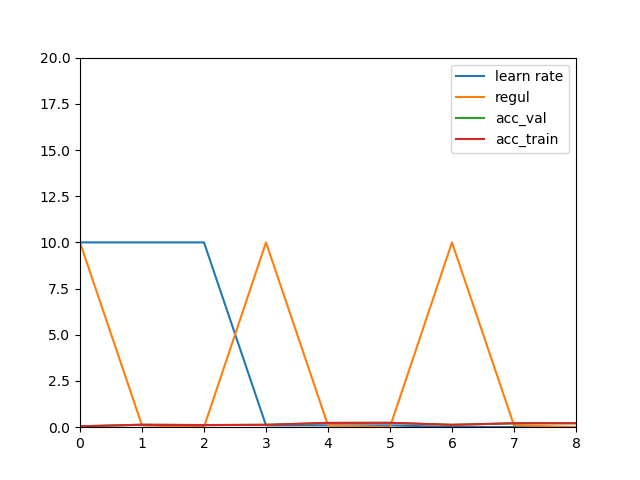

(0, 20)

In [11]:
num_epochs = 300
batch_size = 300

learning_rates = [1e1,1e-1,1e-2]
reg_strengths = [1e1,1e-1,1e-2]

best_classifier = None
best_val_accuracy = None

data:list = list()
train_val:list = list()

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
   
for l in learning_rates:
    for r in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        for i in range(0,num_epochs,10): 
            classifier.fit(train_X, train_y, epochs=10, learning_rate=l, batch_size=300, reg=r)
            pred_val = classifier.predict(val_X)
            pred_train = classifier.predict(train_X)
            accuracy_val = multiclass_accuracy(pred_val, val_y)
            accuracy_train = multiclass_accuracy(pred_train, train_y)
            train_val.append({'acc_val':accuracy_val,'acc_train':accuracy_val,'epoch':l+r})
        data.append({'learn rate':l,'regul':r,'acc_val':accuracy_val,'acc_train':accuracy_val})
        


frame = pd.DataFrame(data)
tr_val = pd.DataFrame(train_val)
print(frame)
frame.plot()
axes = plt.gca()
axes.set_ylim(0,20)

# print('best validation accuracy achieved: %f' % best_val_accuracy)

<IPython.core.display.Javascript object>


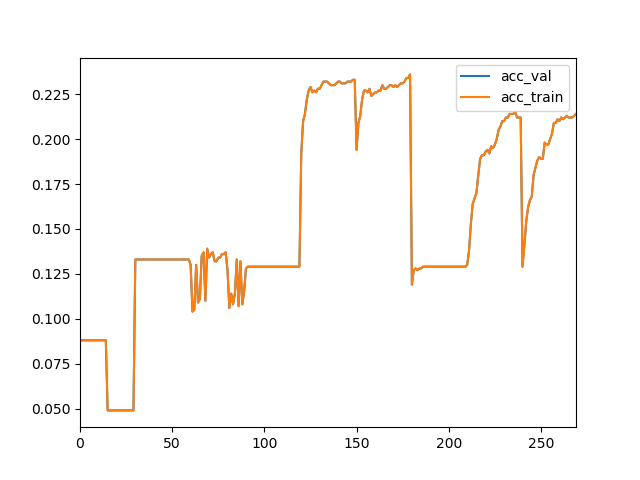

     acc_val  acc_train
0      0.088      0.088
1      0.088      0.088
2      0.088      0.088
3      0.088      0.088
4      0.088      0.088
..       ...        ...
265    0.212      0.212
266    0.212      0.212
267    0.212      0.212
268    0.213      0.213
269    0.214      0.214

[270 rows x 2 columns]


In [31]:
tr_val=pd.DataFrame(train_val)
# plt.plot(tr_val['acc_val'],color = tr_val['epoch']*100)
# plt.plot(tr_val['acc_train'])
tr_val.iloc[:,:-1].plot()
print(tr_val.iloc[:,:-1])

<IPython.core.display.Javascript object>


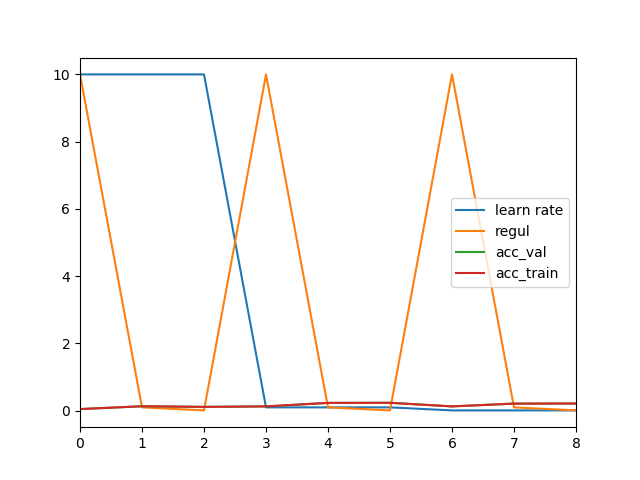

In [22]:
frame.plot()

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [20]:
print(frame)
ax=plt.subplot(projection = '3d')
ax.scatter(frame['learn rate'],frame['regul'],frame['acc_val'],c = frame['acc_val'],cmap = 'viridis')
ax.set_xlabel('learn rate')
ax.set_ylabel('regul')
ax.set_zlabel('accuracy')

   learn rate  regul  acc_val  acc_train
0       10.00  10.00    0.049      0.049
1       10.00   0.10    0.133      0.133
2       10.00   0.01    0.115      0.115
3        0.10  10.00    0.129      0.129
4        0.10   0.10    0.233      0.233
5        0.10   0.01    0.236      0.236
6        0.01  10.00    0.129      0.129
7        0.01   0.10    0.212      0.212
8        0.01   0.01    0.214      0.214


Text(0.5, 0, 'accuracy')

   learn rate  regul  acc_val  acc_train
0         0.1    0.1    0.231      0.231


TypeError: scatter() missing 1 required positional argument: 'y'

   learn rate  regul  acc_val  acc_train
0         0.1    0.1    0.231      0.231


<IPython.core.display.Javascript object>


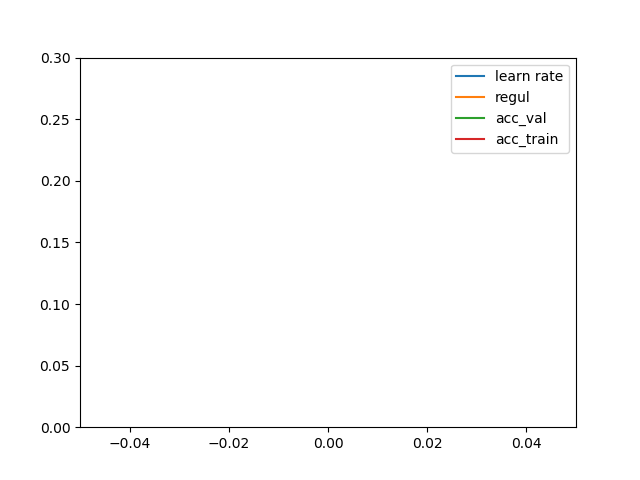

(0, 0.3)

In [56]:
print(frame)
frame.plot()
axes = plt.gca()
axes.set_ylim(0,0.3)

In [73]:
test_class = linear_classifer.LinearSoftmaxClassifier()
test_pred = test_class.pred_rand(val_X)
accuracy = multiclass_accuracy(test_pred, val_y)
print(accuracy)

0.114


# Какой же точности мы добились на тестовых данных?

In [79]:


test_pred = classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.203000


In [18]:
np.__version__

'1.17.0'